### The Drivetrain Approach

There are many accurate models that are of no use to anyone, and many inaccurate models that are highly useful. To ensure that your modeling work is useful in practice, you need to consider how your work will be used. In 2012 Jeremy, along with Margit Zwemer and Mike Loukides, introduced a method called ***the Drivetrain Approach*** for thinking about this issue.

The Drivetrain Approach, illustrated in <<drivetrain>>, was described in detail in ["Designing Great Data Products"](https://www.oreilly.com/radar/drivetrain-approach-data-products/). The basic idea is to start with considering your objective, then think about what actions you can take to meet that objective and what data you have (or can acquire) that can help, and then build a model that you can use to determine the best actions to take to get the best results in terms of your objective.
    
<img src="images/drivetrain-approach.png" id="drivetrain" caption="The Drivetrain Approach">
    
Consider a model in an autonomous vehicle: you want to help a car drive safely from point A to point B without human intervention. Great predictive modeling is an important part of the solution, but it doesn't stand on its own; as products become more sophisticated, it disappears into the plumbing. Someone using a self-driving car is completely unaware of the hundreds (if not thousands) of models and the petabytes of data that make it work. But as data scientists build increasingly sophisticated products, they need a systematic design approach.

We use data not just to generate more data (in the form of predictions), but to produce *actionable outcomes*. That is the goal of the Drivetrain Approach. Start by defining a clear *objective*. For instance, Google, when creating their first search engine, considered "What is the user’s main objective in typing in a search query?" This led them to their objective, which was to "show the most relevant search result." The next step is to consider what *levers* you can pull (i.e., what actions you can take) to better achieve that objective. In Google's case, that was the ranking of the search results. The third step was to consider what new *data* they would need to produce such a ranking; they realized that the implicit information regarding which pages linked to which other pages could be used for this purpose. Only after these first three steps do we begin thinking about building the predictive *models*. Our objective and available levers, what data we already have and what additional data we will need to collect, determine the models we can build. The models will take both the levers and any uncontrollable variables as their inputs; the outputs from the models can be combined to predict the final state for our objective.

## Gathering Data

At the time of writing, Bing Image Search is the best option we know of for finding and downloading images. It's free for up to 1,000 queries per month, and each query can download up to 150 images. However, something better might have come along between when we wrote this and when you're reading the book, so be sure to check out the [book's website](https://book.fast.ai/) for our current recommendation.

DataLoaders is a thin class that just stores whatever DataLoader objects you pass to it, and makes them available as train and valid. Although it's a very simple class, it's very important in fastai: it provides the data for your model. The key functionality in DataLoaders is provided with just these four lines of code

jargon: DataLoaders: A fastai class that stores multiple DataLoader objects you pass to it, normally a train and a valid, although it's possible to have as many as you like. The first two are made available as properties.

Later in the book you'll also learn about the `Dataset` and `Datasets` classes, which have the same relationship.

To turn our downloaded data into a `DataLoaders` object we need to tell fastai at least four things:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

So far we have seen a number of *factory methods* for particular combinations of these things, which are convenient when you have an application and data structure that happen to fit into those predefined methods. For when you don't, fastai has an extremely flexible system called the *data block API*. With this API you can fully customize every stage of the creation of your `DataLoaders`. 

### refer to onenote to learn more about the datablock 

In [8]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

NameError: name 'DataBlock' is not defined

Let's look at each of these arguments in turn. First we provide a tuple where we specify what types we want for the independent and dependent variables: 

```python
blocks=(ImageBlock, CategoryBlock)
```

The *independent variable* is the thing we are using to make predictions from, and the *dependent variable* is our target. In this case, our independent variables are images, and our dependent variables are the categories (type of bear) for each image. We will see many other types of block in the rest of this book.

For this `DataLoaders` our underlying items will be file paths. We have to tell fastai how to get a list of those files. The `get_image_files` function takes a path, and returns a list of all of the images in that path (recursively, by default):

```python
get_items=get_image_files
```

Often, datasets that you download will already have a validation set defined. Sometimes this is done by placing the images for the training and validation sets into different folders. Sometimes it is done by providing a CSV file in which each filename is listed along with which dataset it should be in. There are many ways that this can be done, and fastai provides a very general approach that allows you to use one of its predefined classes for this, or to write your own. In this case, however, we simply want to split our training and validation sets randomly. However, we would like to have the same training/validation split each time we run this notebook, so we fix the random seed (computers don't really know how to create random numbers at all, but simply create lists of numbers that look random; if you provide the same starting point for that list each time—called the *seed*—then you will get the exact same list each time):


```python
splitter=RandomSplitter(valid_pct=0.2, seed=42)
```

The independent variable is often referred to as `x` and the dependent variable is often referred to as `y`. Here, we are telling fastai what function to call to create the labels in our dataset:

```python
get_y=parent_label
```

`parent_label` is a function provided by fastai that simply gets the name of the folder a file is in. Because we put each of our bear images into folders based on the type of bear, this is going to give us the labels that we need.

Our images are all different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several of them (what we call a *mini-batch*). To group them in a big array (usually called a *tensor*) that is going to go through our model, they all need to be of the same size. So, we need to add a transform which will resize these images to the same size. *Item transforms* are pieces of code that run on each individual item, whether it be an image, category, or so forth. fastai includes many predefined transforms; we use the `Resize` transform here:

```python
item_tfms=Resize(128)
```

This command has given us a `DataBlock` object. This is like a *template* for creating a `DataLoaders`. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [ ]:
dls = bears.dataloaders(path)

A `DataLoaders` includes validation and training `DataLoader`s. `DataLoader` is a class that provides batches of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a `DataLoader` fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a `DataLoader`:

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

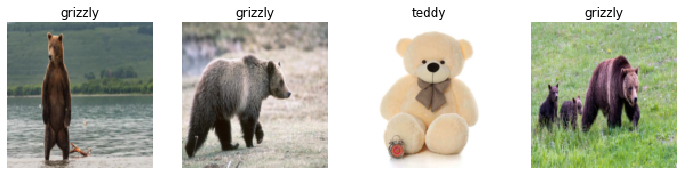

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

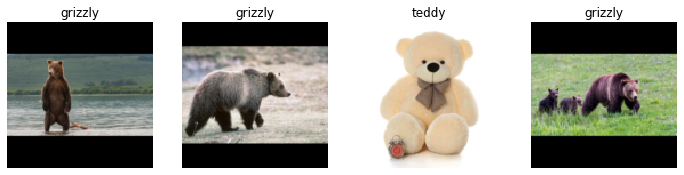

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)